In [1]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


# DATA IMPORT AND VISUALISATION:


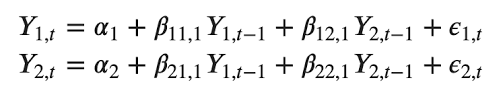

In [3]:
filepath = r"/home/marko/Documents/ElectionLogic/src/2020-polls/2020-172.csv"
macro_data = pd.read_csv(filepath)
print(macro_data.shape)  # (123, 8)
macro_data['HDZ'] = macro_data['HDZ'].astype(float)
macro_data.head()

(172, 9)


,KH,DPMS,Pametno,SDP,HNS,HDZ,HSLS,Most,BM365
0,3.08,13.55,1.82,30.93,0.94,28.28,0.89,4.75,1.65
1,2.96,13.61,1.86,30.94,0.81,28.29,0.89,4.65,1.65
2,2.84,13.66,1.90,30.95,0.68,28.29,0.88,4.55,1.65
3,2.72,13.71,1.93,30.96,0.55,28.29,0.88,4.45,1.64
4,2.60,13.76,1.97,30.97,0.41,28.29,0.87,4.36,1.64


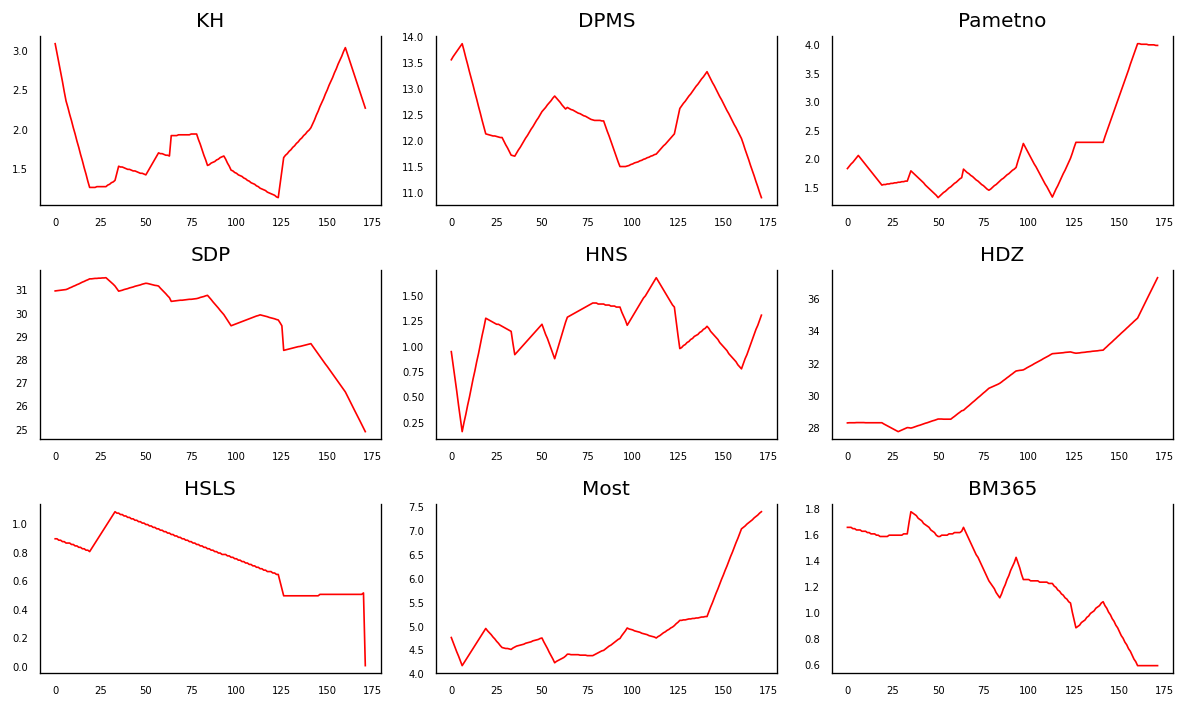

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# DATA STATIONARITY CHECK:

In [6]:
col_names = macro_data.columns

for i in range (len(col_names)):
    ad_fuller_result = adfuller(macro_data[col_names[i]].diff()[1:])
    
    print(col_names[i])
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')
    
    print('\n---------------------\n')

KH
ADF Statistic: -4.061526491468383
p-value: 0.0011204844903851079

---------------------

DPMS
ADF Statistic: -2.9194254050338184
p-value: 0.043135270992539276

---------------------

Pametno
ADF Statistic: -4.414114129737458
p-value: 0.0002802178610394509

---------------------

SDP
ADF Statistic: -5.673279881574429
p-value: 8.821569794961401e-07

---------------------

HNS
ADF Statistic: -4.851922547409977
p-value: 4.322198255066036e-05

---------------------

HDZ
ADF Statistic: -1.5799807104587313
p-value: 0.4936415664931008

---------------------

HSLS
ADF Statistic: -1.4730596509786305
p-value: 0.5467937719302693

---------------------

Most
ADF Statistic: -3.7978652980418084
p-value: 0.0029292314549734157

---------------------

BM365
ADF Statistic: -5.787939033979259
p-value: 4.948961266816444e-07

---------------------



# DATA CAUSALITY CHECK:

In [7]:
col_names = macro_data.columns

for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i == j: continue
        print(col_names[i] + ' causes ' + col_names[j])
        print('------------------')
        granger_1 = grangercausalitytests(macro_data[[col_names[j], col_names[i]]], 4)
        print('------------------')
        print('------------------')


KH causes DPMS
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.3910 , p=0.0000  , df_denom=168, df_num=1
ssr based chi2 test:   chi2=38.0587 , p=0.0000  , df=1
likelihood ratio test: chi2=34.3627 , p=0.0000  , df=1
parameter F test:         F=37.3910 , p=0.0000  , df_denom=168, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4603  , p=0.0885  , df_denom=165, df_num=2
ssr based chi2 test:   chi2=5.0696  , p=0.0793  , df=2
likelihood ratio test: chi2=4.9955  , p=0.0823  , df=2
parameter F test:         F=2.4603  , p=0.0885  , df_denom=165, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9866  , p=0.1181  , df_denom=162, df_num=3
ssr based chi2 test:   chi2=6.2175  , p=0.1015  , df=3
likelihood ratio test: chi2=6.1058  , p=0.1066  , df=3
parameter F test:         F=1.9866  , p=0.1181  , df_denom=162, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

# SORTING DATA TO TRAINING AND TESTING:

In [8]:
#macro_data = macro_data.iloc[:200, :]
print(macro_data.shape)

(172, 9)


In [151]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [152]:
print(test_df.shape)

(12, 9)


# FINDING APPROPRIATE LAG VARIABLE:

In [153]:
model = VAR(train_df.diff()[1:])

In [154]:
sorted_order=model.select_order(maxlags=6)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -61.64      -61.46   1.699e-27      -61.57
1      -68.66     -66.88*   1.517e-30      -67.94
2      -69.32      -65.93   7.945e-31     -67.94*
3     -69.65*      -64.66  5.831e-31*      -67.63
4      -69.04      -62.45   1.129e-30      -66.37
5      -68.64      -60.44   1.843e-30      -65.31
6      -68.32      -58.52   2.883e-30      -64.34
-------------------------------------------------


# FITTING DATA INTO MODEL:

In [168]:
var_model = VARMAX(train_df, order=(3,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                      Statespace Model Results                                                     
Dep. Variable:     ['KH', 'DPMS', 'Pametno', 'SDP', 'HNS', 'HDZ', 'HSLS', 'Most', 'BM365']   No. Observations:                  160
Model:                                                                              VAR(3)   Log Likelihood                -122.480
                                                                               + intercept   AIC                            838.960
Date:                                                                     Sun, 07 Apr 2024   BIC                           1752.287
Time:                                                                             17:03:47   HQIC                          1209.830
Sample:                                                                                  0                                         
                                                                            

# FORECASTING + VISUALISATION:

In [169]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [170]:
predictions.columns=['kh_predicted','dpms_predicted', 'pametno_predicted', 'sdp_predicted','hns_predicted', 'hdz_predicted', 'hsls_predicted', 'most_predicted', 'bm_predicted']
predictions

,kh_predicted,dpms_predicted,pametno_predicted,sdp_predicted,hns_predicted,hdz_predicted,hsls_predicted,most_predicted,bm_predicted
160,2.104138,12.507537,2.558098,28.651416,1.068875,32.722008,0.672699,5.555437,0.960981
161,2.049278,12.503972,2.462682,28.828635,1.085701,32.476141,0.693845,5.455027,1.002653
162,1.979769,12.498527,2.334759,29.087699,1.103247,32.082559,0.721235,5.318315,1.068142
163,1.895390,12.489910,2.175888,29.422782,1.122115,31.551773,0.755273,5.146904,1.155508
164,1.873353,12.484747,2.130730,29.531118,1.125062,31.362959,0.767239,5.098435,1.185331
165,1.852450,12.479882,2.086804,29.640341,1.126810,31.167186,0.779012,5.051170,1.215916
166,1.836103,12.476083,2.051760,29.729714,1.127583,31.003851,0.788617,5.013456,1.241208
167,1.828007,12.474435,2.033536,29.778073,1.127439,30.912948,0.793846,4.993891,1.255101
168,1.821377,12.473172,2.018416,29.818752,1.127126,30.835680,0.798210,4.977641,1.266858
169,1.816669,12.472362,2.007514,29.848410,1.126785,30.778883,0.801382,4.965920,1.275468


In [165]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

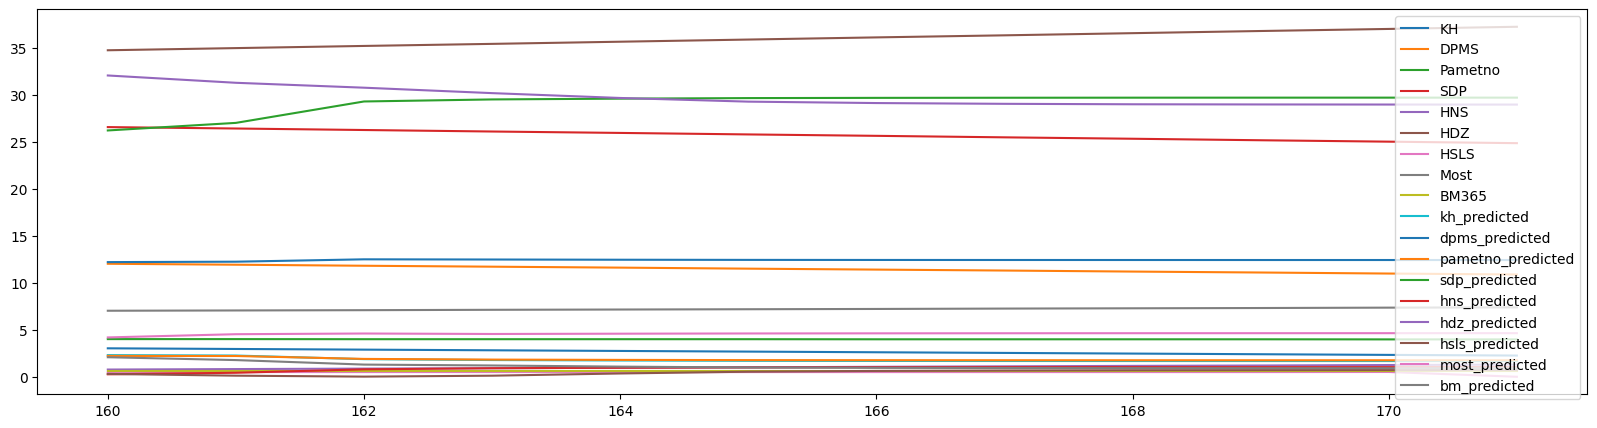

In [166]:
test_vs_pred.plot(figsize=(20,5))

# FORECASTING ERROR CHECK:

In [167]:
from sklearn.metrics import mean_absolute_error
import math 
from statistics import mean

rmse_kh=mean_absolute_error(predictions['kh_predicted'],test_df['KH'])
print('KH ERROR: '+ str(rmse_kh/mean(test_df['KH'])))

rmse_dpms=mean_absolute_error(predictions['dpms_predicted'],test_df['DPMS'])
print('DPMS ERROR: '+ str(rmse_dpms/mean(test_df['DPMS'])))

rmse_pametno=mean_absolute_error(predictions['pametno_predicted'],test_df['Pametno'])
print('Pametno ERROR: '+ str(rmse_pametno/mean(test_df['Pametno'])))

rmse_sdp=mean_absolute_error(predictions['sdp_predicted'],test_df['SDP'])
print('SDP ERROR: '+ str(rmse_sdp/mean(test_df['SDP'])))

rmse_hns=mean_absolute_error(predictions['hns_predicted'],test_df['HNS'])
print('HNS ERROR: '+ str(rmse_hns/mean(test_df['HNS'])))

rmse_hdz=mean_absolute_error(predictions['hdz_predicted'],test_df['HDZ'])
print('HDZ ERROR: '+ str(rmse_hdz/mean(test_df['HDZ'])))

rmse_hsls=mean_absolute_error(predictions['hsls_predicted'],test_df['HSLS'])
print('HSLS ERROR: '+ str(rmse_hsls/mean(test_df['HSLS'])))

rmse_most=mean_absolute_error(predictions['most_predicted'],test_df['Most'])
print('Most ERROR: '+ str(rmse_most/mean(test_df['Most'])))

rmse_bm=mean_absolute_error(predictions['bm_predicted'],test_df['BM365'])
print('BM365 ERROR: '+ str(rmse_sdp/mean(test_df['BM365'])))

KH ERROR: 0.3157602368231975
DPMS ERROR: 0.08296349549579665
Pametno ERROR: 0.5348298031877837
SDP ERROR: 0.13483513277494932
HNS ERROR: 0.1556804642768957
HDZ ERROR: 0.1727832158914658
HSLS ERROR: 0.5909411243180437
Most ERROR: 0.36526088779791255
BM365 ERROR: 5.879230768213928
